# Introduction

This notebook shows how object detection can be done on your own dataset by training YOLOv2. I am going to use soccer playing images as training dataset as an example to detect soccer ball. After finishing this notebook, you will be able to train your own model, and detect objects that you are interested in.

It is really your choice which implementation to use. I happened to choose [darkflow](https://github.com/thtrieu/darkflow) which has been quite popular for Tensorflow support on Github open source hosting service. However, you can build the YOLO model on your own since the [official web-site](https://pjreddie.com/darknet/yolo/) provides its pre-trained weights as an external file.

Here is another choice of implementation called, [tensornets](https://github.com/taehoonlee/tensornets). Please check it out.

## Preparing the Data

__1. Search for your interest__

__2. Collect media files for training (image, video)__
  - Be aware of what your **problem domain** is
    - For example, the wide camera angle shot for a soccer play, the soccer ball is very tiny. However, the ball size gets pretty bigger with the close-up camera shot. These two different types of photo mean the different domains. 
    - In my case, I **collected pictures of only close-up camera shot**.
    - Also, the collected pictures are **soley from 2018 Russia World Cup games**.

__3. Collect media files for testing (image, video)__
  - It is a common sense not to use the same data from the training process for testing purpose. 
  - I just chose some random pictures and a video from internet to check if the trained algorithm performs well with un-seen dataset

__4. If your media file is video, make a lot of screenshot__
  - Here is how to take a bulk screenshot [LINK](https://pibby.livejournal.com/164326.html)
  
__5. Make annotations with drawing rectangles__
  <div stlye="text-align:center;">
      <img src="https://raw.githubusercontent.com/tzutalin/labelImg/master/demo/demo3.jpg"/ style="width:500px;">
  </div>
  
  - Here is a tool to do it [LINK](https://github.com/tzutalin/labelImg)

## Downloading my dataset

I have collected dataset from several youtube videos of highlights in 2018 Russia World Cup. Here is a breif steps how I have done.
1. **downloaded several videos** of highlights in 2018 Russia World Cup from Youtube.
2. produced a bunch of **bulk screenshots** using VLC player.
3. **kept images** that I am **only interested** in.
4. used [LabelImg](https://github.com/tzutalin/labelImg) software to **make annotations** in each image.
5. **located images in './images/' directory and annotations in './annotations/' directory**.

Below is the link of my work. If you want to train on your own machine, please download **'soccer_ball_data.zip'** file and unzip it. You will see three separate folders. **Two of them(images, annotations)** are explained above, and **sample_video folder** contains a sample_video file to verify the result.

https://drive.google.com/drive/folders/1th1odcC5kjEnkZmwooETYlyLsz5AOTph?usp=sharing

## Importing Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from darkflow.net.build import TFNet
import cv2

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Making Your Own Configuration File (cfg)

You need to make a slight change on the configuration file (\*.cfg) to adjust existing model to fit into your own dataset. For example, YOLOv2's CNN model is trained on ImageNet dataset which contains a number of different object classes. However, I only want **one (soccer ball)** object class to detect.

You should do the following to make that change according to Darflow's official explanation.

1. __Copy__ one of the pre-trained configuration file that you are going to use.
  - In my case, I used yolo.cfg.
  
2. __Rename__ the copied configuration file to your custom name
  - In my case, I changed the name yolo.cfg to yolo_custom.cfg.
  
3. Open the configuration file and __change classes in the \[region\] layer__ (the last layer) to the number of classes you are going to train for. 
  - In my case, classes are set to 1.
  
4. __change filters in the \[convolutional\] layer__ (the second to last layer) to num * (classes + 5). 
  - In my case, num is 5 and classes are 2 (ball , goal post) so 5 * (2 + 5) = 35 therefore filters are set to 35 , you can make sure that this will work by inspecting last conv layer in newtowrk architecture , for example 
  
  `Init  |  Yep!  | conv 1x1p0_1    linear           | (?, 19, 19, 35)`

## Specifying Classes of Your Interest

You also need to changes __'labels.txt'__ file included in the root directory. Just specify names of objects. In my case, I removed all text and left __'ball'__ instead.

## Downloading Pre-trained Weights

Please go [here]("https://pjreddie.com/media/files/yolov2.weights") and **download a pre-trained weights** that you are interested. In my case, I downloaded **yolov2.weights**. After downloading is done, **locate the file into 'bin'** directory in the root directory.

<div style="text-align:center;">
    <img src="sample_img/examples1.png"/>
</div>

## Defining Model Options & Build the Model

Before building the model, you need to define options. 

__1. model__: **configuration** file (\*.cfg) that you have defined for your situation

__2. load__: **pre-trained weight** file

__3. batch__: a number of data to train per a batch
  - I set batch size 8 because my GPU card couldn't handle bigger size. My GPU card is **NVIDIA GTX 1080Ti**.

__4. epoch__: how many iterations to train
  - I probably need to set this a bit smaller, but as the result shows I think 100 epochs are just fine

__5. gpu__: set **1.0** if you want to fully utilize your GPU hardware. Otherwise, remove this option.

__6. train__: set **'True'** if your purpose is training

__7. annotation__: **directory** where the annotation files are stored

__8. dataset__: **directory** where the image files are stored

In [3]:
options = {"model": "cfg/yolo_custom.cfg", 
           "load": "bin/yolo.weights",
           "batch": 8,
           "epoch": 100,
           "gpu": 1.0,
           "train": True,
           "annotation": "./annotations/",
           "dataset": "./images/"}

In [4]:
tfnet = TFNet(options)

Parsing ./cfg/yolo.cfg
Parsing cfg/yolo_custom.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.014986753463745117s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?,

## Training the Model

Training took about **an hour** on NVIDIA GTX 1080Ti

In [5]:
tfnet.train()


cfg/yolo_custom.cfg parsing ./annotations/
Parsing for ['ball', 'goal post'] 
[====================>]100%  scene21261.xml
Statistics:
ball: 177
goal post: 54
Dataset size: 191
Dataset of 191 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 8
	Epoch number  : 100
	Backup every  : 2000
step 1 - loss 222.72128295898438 - moving ave loss 222.72128295898438
step 2 - loss 219.80368041992188 - moving ave loss 222.42952270507814
step 3 - loss 218.88107299804688 - moving ave loss 222.07467773437503
step 4 - loss 216.67306518554688 - moving ave loss 221.53451647949223
step 5 - loss 215.97447204589844 - moving ave loss 220.97851203613286
step 6 - loss 215.07479858398438 - moving ave loss 220.38814069091802
step 7 - loss 213.70199584960938 - moving ave loss 219.71952620678718
step 8 - loss 212.28094482421875 - moving ave loss 218.97566806853035
step 9 - loss 211.2503204345703 - moving ave loss 218.20313330513434
step 10 - loss 210.95358276367188 - moving ave loss 217.4781

In [6]:
# this line of code lets you save the built graph to a protobuf file (.pb)
# this step is unnecessary for this notebook
tfnet.savepb()

## Loading from the Latest Checkpoint

This cell shows how to load custom trained model from the checkpoint. It will easy your work.

__1. model__: the model configuration that you used (\*.cfg)

__2. load__: set -1. In this way, the latest checkpoint will be loaded.

In [27]:
options = {"model": "cfg/yolo_custom.cfg",
           "load": -1,
           "gpu": 1.0}

In [28]:
tfnet2 = TFNet(options)

Parsing cfg/yolo_custom.cfg
Loading None ...
Finished in 0.0s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 76, 128)
 Init  |

## load_from_ckpt()

By calling load_from_ckpt() method in TFNet, it will load pre-trained parameters from the checkpoint that you just specified in options.

In [29]:
tfnet2.load_from_ckpt()

Loading from ./ckpt/yolo_custom-2300
INFO:tensorflow:Restoring parameters from ./ckpt/yolo_custom-2300


## Predicting on a Image

This part is almost identical to my previous notebook [Object-Detection-YOLOv2-Darkflow](https://github.com/deep-diver/Object-Detection-YOLOv2-Darkflow). If you wonder some process, please check it out. I have also written some more information about the basic in [medium](https://towardsdatascience.com/yolov2-object-detection-using-darkflow-83db6aa5cf5f), so please check it out.

In [35]:
import pprint as pp

original_img = cv2.imread("sample_img/test_image1.jpg")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
results = tfnet2.return_predict(original_img)
print(results)

[{'confidence': 0.6912182, 'label': 'ball', 'bottomright': {'y': 447, 'x': 440}, 'topleft': {'y': 388, 'x': 379}}]


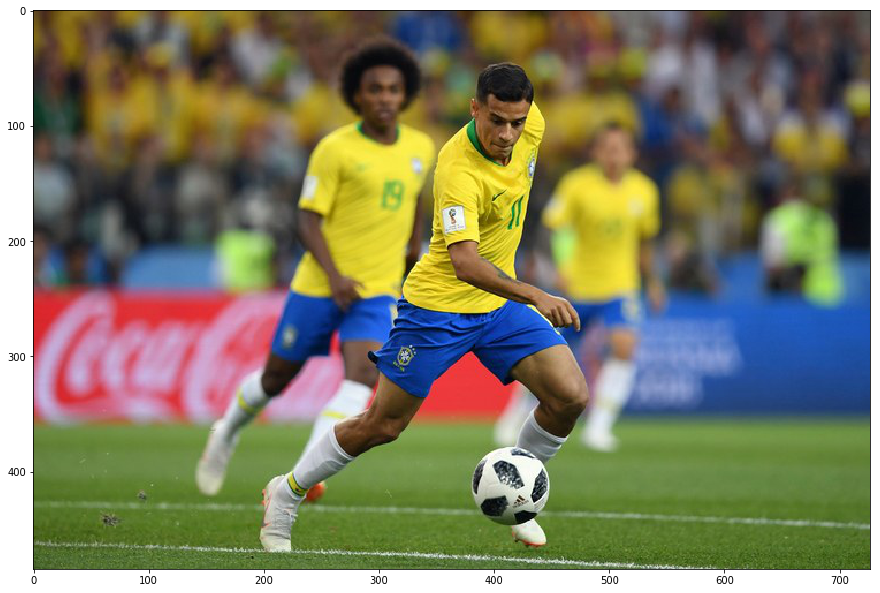

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(original_img)

In [37]:
def boxing(original_img , predictions):
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))
        
        if confidence > 0.3:
            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
        
    return newImage

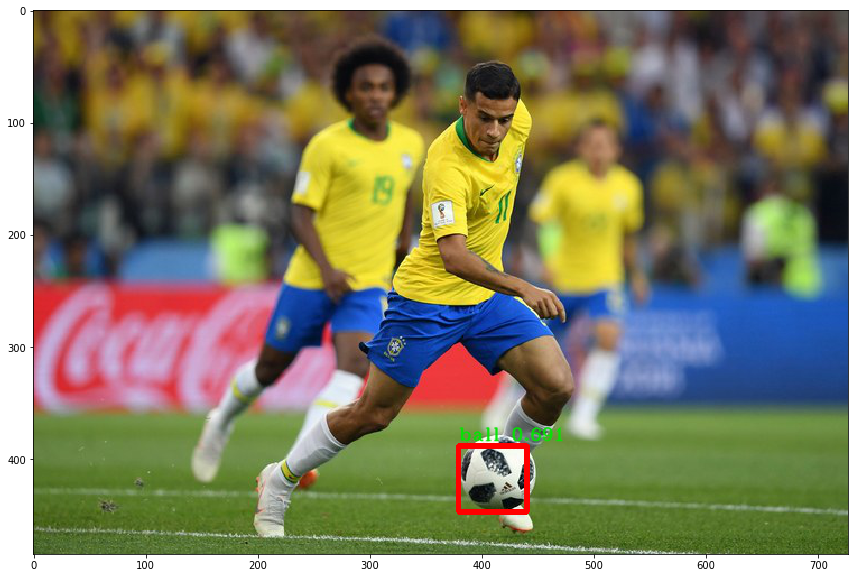

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(boxing(original_img, results))

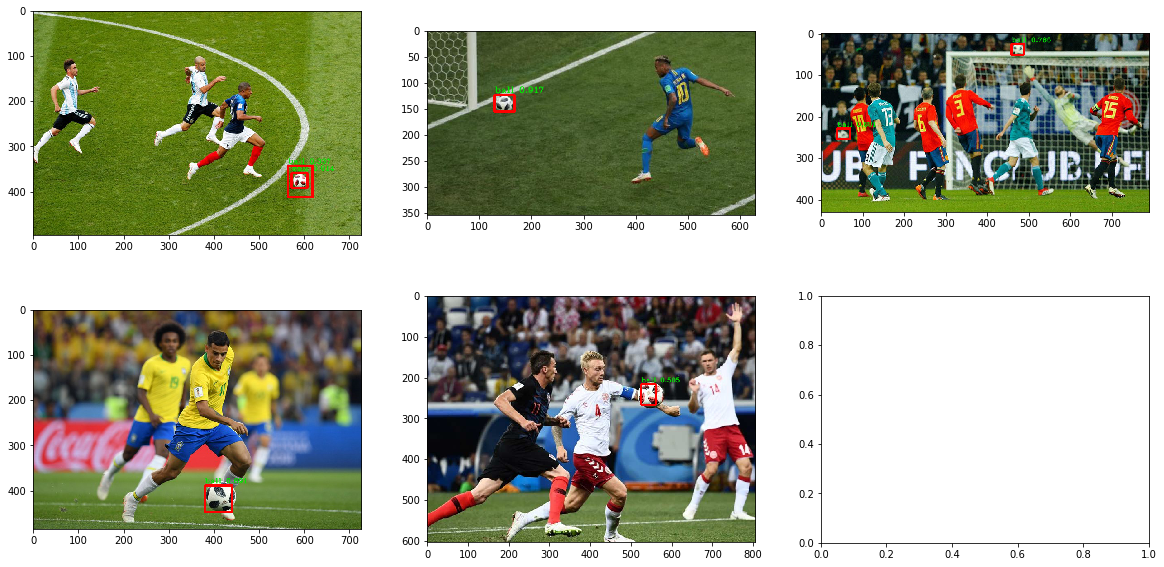

In [50]:
from math import ceil

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(5):
    original_img = cv2.imread("sample_img/test_image" + str(i+1) + ".jpg")
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    results = tfnet2.return_predict(original_img)
    
    ax[ceil(i/3)-1, i%3].imshow(boxing(original_img, results))

## Predicting on a Video

In [33]:
cap = cv2.VideoCapture('./sample_video/test_video.avi')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('./sample_video/output.avi',fourcc, 20.0, (int(width), int(height)))

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)      
        results = tfnet2.return_predict(frame)
        
        new_frame = boxing(frame, results)

        # Display the resulting frame
        out.write(new_frame)
        cv2.imshow('frame', new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()

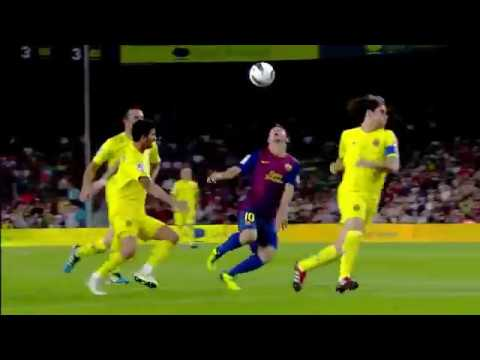

In [52]:
from IPython.display import YouTubeVideo
YouTubeVideo('1MwIVcni0P4')